# Final Model

C:\Users\Harsh\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'paypal.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\Harsh\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.paypal.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\Harsh\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.paypal.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Brand (matched): paypal
Comparing reference: paypal_ref.png ↔ User screenshot: paypal_user.png
Final Similarity Score: 0.991
Details: {'image': 1.0, 'color': 0.9999992063988374, 'text': 0.9104068118978381}
✅ Looks Safe

--- Explainability ---
- Image contribution: 0.500 (raw=1.000, weight=0.5)
- Color contribution: 0.400 (raw=1.000, weight=0.4)
- Text contribution: 0.091 (raw=0.910, weight=0.1)
Total Score: 0.991


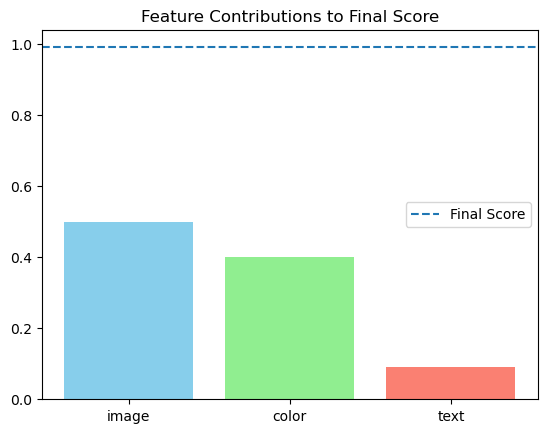

In [3]:
from PIL import Image
import imagehash, cv2, numpy as np, pytesseract, re, os, time, base64, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from rapidfuzz import process
from urllib.parse import urlparse
import socket
import requests

# ---------- Config ----------
BRANDS_FOLDER = "C:/Users/Harsh/Documents/Hackathon/Brands"
USER_FOLDER   = "C:/Users/Harsh/Documents/Hackathon/User"

os.makedirs(BRANDS_FOLDER, exist_ok=True)
os.makedirs(USER_FOLDER,   exist_ok=True)

# ---------- URL Utilities ----------
def normalize_url(url: str) -> str:
    """Ensure scheme; return normalized URL string."""
    if not re.match(r'^[a-zA-Z]+://', url or ''):
        url = "https://" + url.strip()
    return url

def is_file_input(url_or_path: str) -> bool:
    """True if input is a local image (path) or file:// URL."""
    if str(url_or_path).lower().startswith("file://"):
        return True
    # If it looks like a path and exists, treat as image
    return os.path.exists(url_or_path)

def extract_domain(url: str):
    """Robust domain extraction (ignores file://)"""
    if is_file_input(url):
        return None
    try:
        p = urlparse(url)
        host = p.hostname or ""
        # take second-level (brand) if possible: e.g., paypal from paypal.com
        m = re.match(r"^([a-z0-9-]+)\.", host, re.I)
        return (m.group(1).lower() if m else host.split(".")[0].lower()) if host else None
    except Exception:
        return None

def check_dns(url: str, timeout=3) -> bool:
    try:
        host = urlparse(url).hostname
        if not host:
            return False
        socket.setdefaulttimeout(timeout)
        socket.gethostbyname(host)
        return True
    except Exception:
        return False

def check_http(url: str, timeout=6) -> bool:
    """Lightweight HTTP reachability check; ignores TLS errors."""
    try:
        r = requests.get(url, timeout=timeout, allow_redirects=True, verify=False)
        return 200 <= r.status_code < 400
    except Exception:
        return False

# ---------- Selenium Screenshot ----------
def capture_viewport_screenshot(url, save_path, width=1280, height=720, retries=1):
    """Viewport screenshot with timeouts + retries. Returns save_path or None."""
    options = Options()
    options.add_argument("--headless=new")
    options.add_argument("--disable-gpu")
    options.add_argument("--ignore-certificate-errors")
    options.add_argument("--allow-insecure-localhost")
    options.add_argument(f"--window-size={width},{height}")
    driver = None

    for attempt in range(retries + 1):
        try:
            driver = webdriver.Chrome(options=options)
            driver.set_page_load_timeout(12)
            driver.get(url)
            # wait a bit for layout
            time.sleep(2.5)
            screenshot = driver.get_screenshot_as_base64()
            with open(save_path, "wb") as f:
                f.write(base64.b64decode(screenshot))
            return save_path
        except Exception as e:
            if attempt >= retries:
                print(f"❌ Error capturing screenshot (attempt {attempt+1}): {e}")
                return None
            time.sleep(1.5)  # brief backoff then retry
        finally:
            if driver:
                try:
                    driver.quit()
                except Exception:
                    pass
            driver = None

# ---------- Image Normalization ----------
def normalize_image(img_path, target_size=(1280, 720), bg_color=(255,255,255)):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception:
        # If PIL fails, return a blank canvas to avoid crashes
        return Image.new("RGB", target_size, bg_color)

    img.thumbnail(target_size, Image.Resampling.LANCZOS)
    background = Image.new("RGB", target_size, bg_color)
    offset = ((target_size[0] - img.width) // 2,
              (target_size[1] - img.height) // 2)
    background.paste(img, offset)
    return background

# ---------- OCR Preprocessing ----------
def preprocess_for_ocr(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        # gentle denoise and binarization
        img = cv2.medianBlur(img, 3)
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY)[1]
        return img
    except Exception:
        return None

def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9 ]', ' ', text).lower().strip()

# ---------- Similarity Functions ----------
def image_similarity(img1_path, img2_path):
    img1 = normalize_image(img1_path)
    img2 = normalize_image(img2_path)
    try:
        ph = imagehash.phash(img1)
        dh = imagehash.dhash(img1)
        ph2 = imagehash.phash(img2)
        dh2 = imagehash.dhash(img2)
        phash_sim = 1 - (ph - ph2) / (len(ph.hash) ** 2)
        dhash_sim = 1 - (dh - dh2) / (len(dh.hash) ** 2)
        return (phash_sim + dhash_sim) / 2
    except Exception:
        return 0.0

def color_similarity(img1_path, img2_path, bins=32):
    try:
        img1 = np.array(normalize_image(img1_path))
        img2 = np.array(normalize_image(img2_path))
        hist1 = cv2.calcHist([img1],[0,1,2],None,[bins,bins,bins],[0,256,0,256,0,256])
        hist2 = cv2.calcHist([img2],[0,1,2],None,[bins,bins,bins],[0,256,0,256,0,256])
        hist1 = cv2.normalize(hist1, hist1).flatten()
        hist2 = cv2.normalize(hist2, hist2).flatten()
        return float(cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL))
    except Exception:
        return 0.0

def text_similarity(img1_path, img2_path):
    img1 = preprocess_for_ocr(img1_path)
    img2 = preprocess_for_ocr(img2_path)
    if img1 is None or img2 is None:
        return 0.0

    try:
        text1 = clean_text(pytesseract.image_to_string(img1))
        text2 = clean_text(pytesseract.image_to_string(img2))
        if not text1 or not text2:
            return 0.0

        # TF-IDF cosine similarity
        vectorizer = TfidfVectorizer().fit([text1, text2])
        vectors = vectorizer.transform([text1, text2])
        tfidf_sim = float(cosine_similarity(vectors[0], vectors[1])[0][0])

        # Jaccard similarity
        set1, set2 = set(text1.split()), set(text2.split())
        jaccard_sim = (len(set1 & set2) / len(set1 | set2)) if set1 and set2 else 0.0

        return (tfidf_sim + jaccard_sim) / 2
    except Exception:
        return 0.0

def website_similarity(ref_img, target_img, weights=(0.5,0.4,0.1)):
    img_sim = image_similarity(ref_img, target_img)
    col_sim = color_similarity(ref_img, target_img)
    txt_sim = text_similarity(ref_img, target_img)
    final_score = weights[0]*img_sim + weights[1]*col_sim + weights[2]*txt_sim
    return final_score, {"image": img_sim, "color": col_sim, "text": txt_sim}, weights

# ---------- Fuzzy Brand Detection ----------
def fuzzy_match_brand(domain):
    brands = [os.path.splitext(f)[0].replace("_ref","") for f in os.listdir(BRANDS_FOLDER) if f.lower().endswith(".png")]
    if not brands:
        print("❌ No brand reference images found in dataset.")
        return None
    best = process.extractOne(domain, brands)
    if not best:
        return None
    best_match, score, _ = best
    if score >= 75:
        print(f"🔍 Fuzzy matched '{domain}' → '{best_match}' (score={round(score,1)})")
        return best_match
    return None

# ---------- Explainability ----------
def explain_score(details, weights, final_score):
    keys = ["image", "color", "text"]
    contributions = {k: details[k]*weights[i] for i, k in enumerate(keys)}
    print("\n--- Explainability ---")
    for i, k in enumerate(keys):
        print(f"- {k.capitalize()} contribution: {contributions[k]:.3f} (raw={details[k]:.3f}, weight={weights[i]})")
    print(f"Total Score: {final_score:.3f}")

    # Simple bar viz
    try:
        plt.bar(contributions.keys(), contributions.values(), color=["skyblue","lightgreen","salmon"])
        plt.axhline(y=final_score, linestyle="--", label="Final Score")
        plt.title("Feature Contributions to Final Score")
        plt.legend()
        plt.show()
    except Exception:
        pass

# ---------- Main Check ----------
def check_website(user_input):
    """
    user_input can be:
      - URL (with/without scheme)
      - file://... URI
      - local image path
    """
    # If it's a local image (file or path), we skip Selenium and just compare against dataset by fuzzy brand guess.
    if is_file_input(user_input):
        # Try to guess brand from filename for convenience
        fname = os.path.basename(user_input)
        guess = re.split(r'[^a-z0-9]+', os.path.splitext(fname.lower())[0])
        guess = next((g for g in guess if g), None)
        brand_name = guess if guess else None
        if not brand_name:
            print("❌ Local image provided but cannot guess brand name from filename. Rename like 'paypal_user.png'.")
            return

        # Fuzzy match to dataset
        matched = fuzzy_match_brand(brand_name) or brand_name
        ref_img = os.path.join(BRANDS_FOLDER, f"{matched}_ref.png")
        if not os.path.exists(ref_img):
            print(f"❌ No reference image found for '{matched}'. Place '{matched}_ref.png' in {BRANDS_FOLDER}.")
            return

        user_img = user_input if user_input.lower().startswith("file://") else user_input
        if user_img.lower().startswith("file://"):
            user_img = user_img.replace("file://", "")

        score, details, weights = website_similarity(ref_img, user_img)
        print(f"\nBrand (matched): {matched}")
        print(f"Comparing reference: {os.path.basename(ref_img)} ↔ User image: {os.path.basename(user_img)}")
        print(f"Final Similarity Score: {score:.3f}")
        print("Details:", details)
        print("✅ Looks Safe" if score >= 0.75 or details["image"] >= 0.8 else "⚠️ Phishing Suspected")
        explain_score(details, weights, score)
        return

    # Otherwise treat as URL
    url = normalize_url(user_input)
    domain = extract_domain(url)
    if not domain:
        print("❌ Invalid URL (cannot extract domain).")
        return

    # Accessibility checks
    if not check_dns(url):
        print(f"❌ DNS resolution failed for '{url}'. The domain may not exist.")
        return
    if not check_http(url):
        print(f"❌ '{url}' is not reachable (HTTP check failed).")
        return

    # Exact or fuzzy match brand
    brand_name = domain
    ref_img = os.path.join(BRANDS_FOLDER, f"{brand_name}_ref.png")
    if not os.path.exists(ref_img):
        brand_name = fuzzy_match_brand(domain)
        if not brand_name:
            print(f"❌ No reference found for '{domain}' (even after fuzzy match).")
            return
        ref_img = os.path.join(BRANDS_FOLDER, f"{brand_name}_ref.png")

    # Capture user screenshot
    user_img = os.path.join(USER_FOLDER, f"{brand_name}_user.png")
    saved = capture_viewport_screenshot(url, user_img, retries=1)
    if not saved:
        print("❌ Failed to capture user screenshot (network/timeout/blocked).")
        return

    # Compare
    score, details, weights = website_similarity(ref_img, user_img)
    print(f"\nBrand (matched): {brand_name}")
    print(f"Comparing reference: {os.path.basename(ref_img)} ↔ User screenshot: {os.path.basename(user_img)}")
    print(f"Final Similarity Score: {score:.3f}")
    print("Details:", details)
    print("✅ Looks Safe" if score >= 0.75 or details["image"] >= 0.8 else "⚠️ Phishing Suspected")
    explain_score(details, weights, score)

# ---------- Example Run ----------
if __name__ == "__main__":
    # Examples:
    # 1) Good/Bad URL
    user_input = "paypal.com"
    # user_input = "https://this-domain-should-not-exist-12345.com"

    # 2) Local image path or file:// URI
    # user_input = r"C:\Users\Harsh\Downloads\paypal_user.png"
    # user_input = "file:///C:/Users/Harsh/Downloads/paypal_user.png"

    # user_input = r"file:///C:/Users/Harsh/Documents/Hackathon/User/flipkart_user.png"  # change to test
    check_website(user_input)
